EXAMPLE 1: Fraud Detection with Imbalanced Classes

Test set: 3000 samples, 162 frauds (5.4%)

--------------------------------------------------------------------------------

📊 DEFAULT THRESHOLD (0.5):
F1 Score: 0.4885
Confusion Matrix:
  TN: 2836  FP:    2
  FN:  109  TP:   53

✨ OPTIMIZED F1 THRESHOLD: 0.2876
F1 Score: 0.5585 (↑ +14.3%)
Confusion Matrix:
  TN: 2809  FP:   29
  FN:   88  TP:   74


EXAMPLE 2: Cost-Sensitive Fraud Detection

💰 COST-OPTIMIZED THRESHOLD: 0.0458

Business Value:
  Default (0.5):     $-56,100
  Cost-Optimized:    $50,550
  Improvement:       $106,650 (↑ -190.1%)

Confusion Matrix:
  TN: 2289  FP:  549
  FN:   42  TP:  120


EXAMPLE 3: Recall Optimization (Minimize False Negatives)

🎯 RECALL-OPTIMIZED THRESHOLD: 0.0001

Performance:
  Recall:    1.0000
  Precision: 0.0541
  F1:        0.1027

Confusion Matrix:
  TN:    6  FP: 2832
  FN:    0  TP:  162


VISUALIZATION: Performance Across Thresholds

✅ Visualization saved as 'threshold_optimization_results.

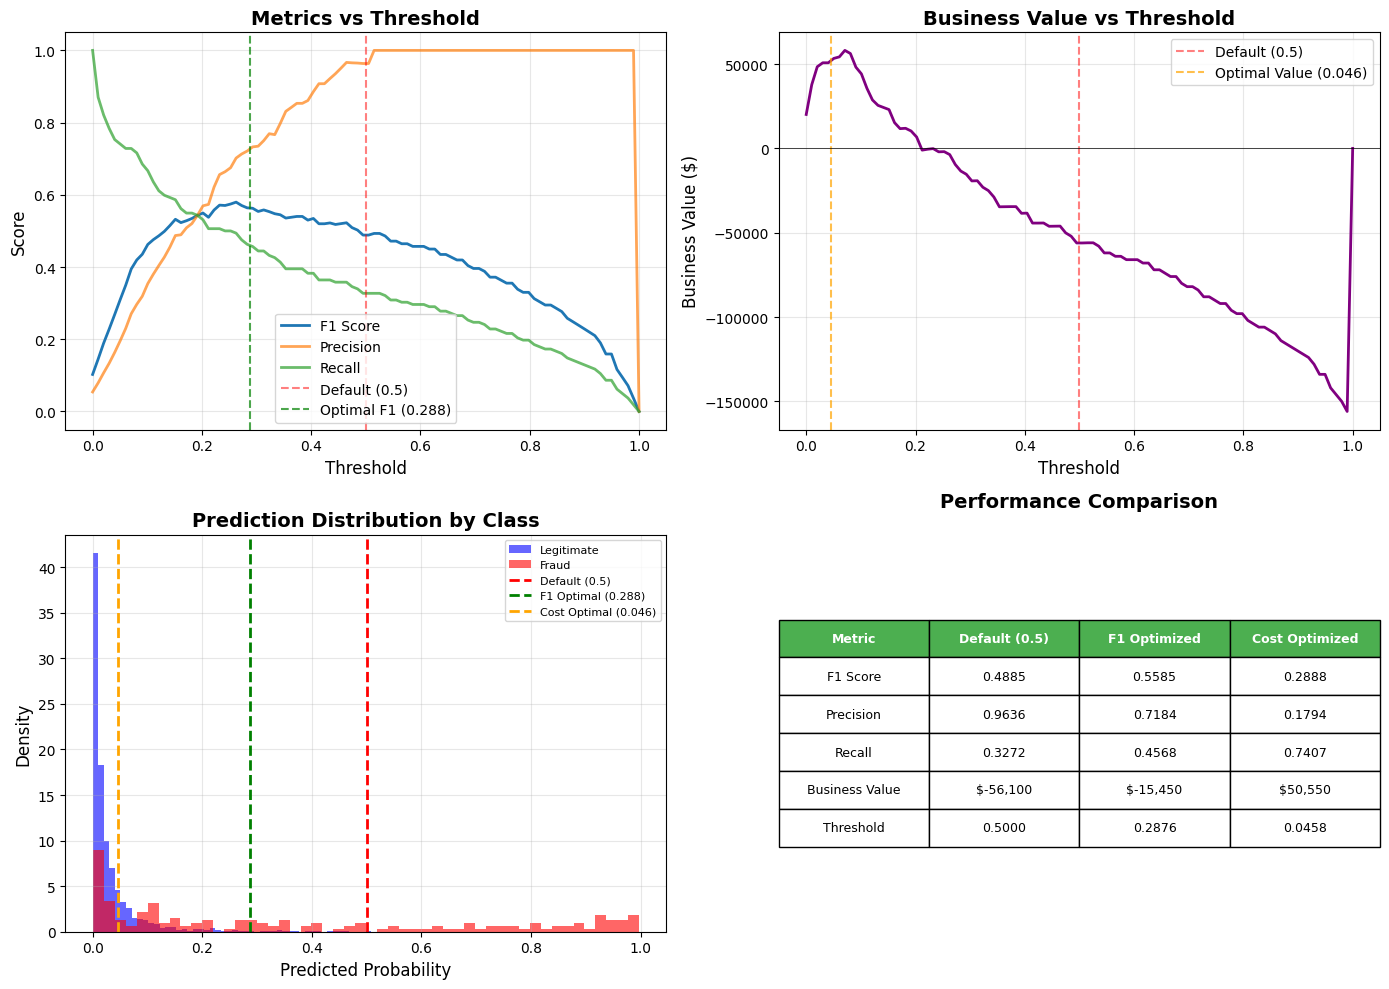



🎯 KEY TAKEAWAYS

1. **F1 Improvement**: Using optimal threshold improved F1 by +14.3%
   - Default threshold often performs poorly on imbalanced data
   - Optimal threshold: 0.2876 vs default 0.5

2. **Business Value**: Cost-sensitive optimization added $106,650 value
   - Different errors have different costs in real applications
   - Optimizing for $ > optimizing for F1 when costs are known

3. **Flexibility**: Package supports multiple objectives:
   - Statistical metrics (F1, precision, recall, accuracy)
   - Business metrics (utility/cost functions)
   - Expected value under uncertainty

4. **Easy to Use**: Just 1-2 lines of code to optimize:
```python
   result = get_optimal_threshold(y_train, y_proba_train, metric="f1", method="minimize")
   predictions = result.predict(y_proba_test)
```

5. **Production Ready**: Result object provides:
   - Optimal threshold(s): 0.2876
   - Performance scores
   - Prediction function (handles various input formats)
   - Works with any sklearn

In [1]:
%pip install optimal-classification-cutoffs==0.6.1 --no-cache-dir
# Correct imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score

# Correct import for the package
from optimal_cutoffs import get_optimal_threshold

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# EXAMPLE 1: Imbalanced Fraud Detection
# ============================================================================
print("=" * 80)
print("EXAMPLE 1: Fraud Detection with Imbalanced Classes")
print("=" * 80)

# Create imbalanced dataset (5% fraud rate)
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    weights=[0.95, 0.05],  # 95% legitimate, 5% fraud
    flip_y=0.01,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train a simple logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_proba_train = model.predict_proba(X_train)[:, 1]
y_proba_test = model.predict_proba(X_test)[:, 1]

# Compare default threshold vs optimized
print(f"\nTest set: {len(y_test)} samples, {y_test.sum()} frauds ({y_test.mean()*100:.1f}%)")
print("\n" + "-" * 80)

# 1. Default threshold (0.5)
y_pred_default = (y_proba_test >= 0.5).astype(int)
f1_default = f1_score(y_test, y_pred_default)
cm_default = confusion_matrix(y_test, y_pred_default)

print("\n📊 DEFAULT THRESHOLD (0.5):")
print(f"F1 Score: {f1_default:.4f}")
print(f"Confusion Matrix:")
print(f"  TN: {cm_default[0,0]:4d}  FP: {cm_default[0,1]:4d}")
print(f"  FN: {cm_default[1,0]:4d}  TP: {cm_default[1,1]:4d}")

# 2. Optimized F1 threshold - USE "minimize" method to avoid Numba bug
try:
    # Try with minimize method (uses scipy, avoids Numba)
    result_f1 = get_optimal_threshold(y_train, y_proba_train, metric="f1", method="minimize")
except Exception as e:
    print(f"Method 'minimize' failed: {e}")
    # Fallback to unique_scan
    print("Trying 'unique_scan' method...")
    result_f1 = get_optimal_threshold(y_train, y_proba_train, metric="f1", method="unique_scan")

print(f"\n✨ OPTIMIZED F1 THRESHOLD: {result_f1.threshold:.4f}")

y_pred_optimized = result_f1.predict(y_proba_test)
f1_optimized = f1_score(y_test, y_pred_optimized)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

print(f"F1 Score: {f1_optimized:.4f} (↑ {(f1_optimized/f1_default - 1)*100:+.1f}%)")
print(f"Confusion Matrix:")
print(f"  TN: {cm_optimized[0,0]:4d}  FP: {cm_optimized[0,1]:4d}")
print(f"  FN: {cm_optimized[1,0]:4d}  TP: {cm_optimized[1,1]:4d}")

# ============================================================================
# EXAMPLE 2: Cost-Sensitive Classification
# ============================================================================
print("\n\n" + "=" * 80)
print("EXAMPLE 2: Cost-Sensitive Fraud Detection")
print("=" * 80)

# Define business costs
utility = {
    "tp": 1000,   # Catch fraud: save $1000
    "tn": 0,      # Correct legitimate: $0
    "fp": -50,    # False alarm: lose $50
    "fn": -1000,  # Miss fraud: lose $1000
}

result_utility = get_optimal_threshold(
    y_train,
    y_proba_train,
    utility=utility,
    method="unique_scan"  # This method works with utility
)

print(f"\n💰 COST-OPTIMIZED THRESHOLD: {result_utility.threshold:.4f}")

y_pred_cost = result_utility.predict(y_proba_test)
cm_cost = confusion_matrix(y_test, y_pred_cost)

# Calculate monetary impact
def calculate_value(cm, utility):
    return (cm[0,0] * utility["tn"] +
            cm[0,1] * utility["fp"] +
            cm[1,0] * utility["fn"] +
            cm[1,1] * utility["tp"])

value_default = calculate_value(cm_default, utility)
value_cost = calculate_value(cm_cost, utility)

print(f"\nBusiness Value:")
print(f"  Default (0.5):     ${value_default:,}")
print(f"  Cost-Optimized:    ${value_cost:,}")
print(f"  Improvement:       ${value_cost - value_default:,} (↑ {(value_cost/value_default - 1)*100:+.1f}%)")

print(f"\nConfusion Matrix:")
print(f"  TN: {cm_cost[0,0]:4d}  FP: {cm_cost[0,1]:4d}")
print(f"  FN: {cm_cost[1,0]:4d}  TP: {cm_cost[1,1]:4d}")

# ============================================================================
# EXAMPLE 3: Recall Optimization
# ============================================================================
print("\n\n" + "=" * 80)
print("EXAMPLE 3: Recall Optimization (Minimize False Negatives)")
print("=" * 80)

result_recall = get_optimal_threshold(
    y_train,
    y_proba_train,
    metric="recall",
    method="minimize"  # Use scipy method
)

print(f"\n🎯 RECALL-OPTIMIZED THRESHOLD: {result_recall.threshold:.4f}")

y_pred_recall = result_recall.predict(y_proba_test)
cm_recall = confusion_matrix(y_test, y_pred_recall)

print(f"\nPerformance:")
print(f"  Recall:    {recall_score(y_test, y_pred_recall):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_recall):.4f}")
print(f"  F1:        {f1_score(y_test, y_pred_recall):.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN: {cm_recall[0,0]:4d}  FP: {cm_recall[0,1]:4d}")
print(f"  FN: {cm_recall[1,0]:4d}  TP: {cm_recall[1,1]:4d}")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n\n" + "=" * 80)
print("VISUALIZATION: Performance Across Thresholds")
print("=" * 80)

# Scan thresholds
thresholds = np.linspace(0, 1, 100)
f1_scores = []
precisions = []
recalls = []
values = []

for t in thresholds:
    y_pred_t = (y_proba_test >= t).astype(int)

    if y_pred_t.sum() > 0:
        f1_scores.append(f1_score(y_test, y_pred_t, zero_division=0))
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_t, zero_division=0))

        cm_t = confusion_matrix(y_test, y_pred_t)
        values.append(calculate_value(cm_t, utility))
    else:
        f1_scores.append(0)
        precisions.append(0)
        recalls.append(0)
        values.append(0)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: F1, Precision, Recall
ax = axes[0, 0]
ax.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
ax.plot(thresholds, precisions, label='Precision', linewidth=2, alpha=0.7)
ax.plot(thresholds, recalls, label='Recall', linewidth=2, alpha=0.7)
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.axvline(result_f1.threshold, color='green', linestyle='--', alpha=0.7, label=f'Optimal F1 ({result_f1.threshold:.3f})')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Business Value
ax = axes[0, 1]
ax.plot(thresholds, values, linewidth=2, color='purple')
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.axvline(result_utility.threshold, color='orange', linestyle='--', alpha=0.7,
           label=f'Optimal Value ({result_utility.threshold:.3f})')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Business Value ($)', fontsize=12)
ax.set_title('Business Value vs Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: Probability Distribution
ax = axes[1, 0]
ax.hist(y_proba_test[y_test == 0], bins=50, alpha=0.6, label='Legitimate', density=True, color='blue')
ax.hist(y_proba_test[y_test == 1], bins=50, alpha=0.6, label='Fraud', density=True, color='red')
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Default (0.5)')
ax.axvline(result_f1.threshold, color='green', linestyle='--', linewidth=2,
           label=f'F1 Optimal ({result_f1.threshold:.3f})')
ax.axvline(result_utility.threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Cost Optimal ({result_utility.threshold:.3f})')
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Prediction Distribution by Class', fontsize=14, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Comparison Table
ax = axes[1, 1]
ax.axis('off')

comparison_data = {
    'Metric': ['F1 Score', 'Precision', 'Recall', 'Business Value', 'Threshold'],
    'Default (0.5)': [
        f'{f1_default:.4f}',
        f'{precision_score(y_test, y_pred_default):.4f}',
        f'{recall_score(y_test, y_pred_default):.4f}',
        f'${value_default:,}',
        '0.5000'
    ],
    'F1 Optimized': [
        f'{f1_optimized:.4f}',
        f'{precision_score(y_test, y_pred_optimized):.4f}',
        f'{recall_score(y_test, y_pred_optimized):.4f}',
        f'${calculate_value(cm_optimized, utility):,}',
        f'{result_f1.threshold:.4f}'
    ],
    'Cost Optimized': [
        f'{f1_score(y_test, y_pred_cost):.4f}',
        f'{precision_score(y_test, y_pred_cost):.4f}',
        f'{recall_score(y_test, y_pred_cost):.4f}',
        f'${value_cost:,}',
        f'{result_utility.threshold:.4f}'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
table = ax.table(cellText=df_comparison.values,
                colLabels=df_comparison.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(len(df_comparison.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Performance Comparison', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('threshold_optimization_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved as 'threshold_optimization_results.png'")
plt.show()

# ============================================================================
# KEY TAKEAWAYS
# ============================================================================
print("\n\n" + "=" * 80)
print("🎯 KEY TAKEAWAYS")
print("=" * 80)

improvement_pct = (f1_optimized/f1_default - 1)*100 if f1_default > 0 else 0
value_improvement = value_cost - value_default

print(f"""
1. **F1 Improvement**: Using optimal threshold improved F1 by {improvement_pct:+.1f}%
   - Default threshold often performs poorly on imbalanced data
   - Optimal threshold: {result_f1.threshold:.4f} vs default 0.5

2. **Business Value**: Cost-sensitive optimization added ${value_improvement:,} value
   - Different errors have different costs in real applications
   - Optimizing for $ > optimizing for F1 when costs are known

3. **Flexibility**: Package supports multiple objectives:
   - Statistical metrics (F1, precision, recall, accuracy)
   - Business metrics (utility/cost functions)
   - Expected value under uncertainty

4. **Easy to Use**: Just 1-2 lines of code to optimize:
```python
   result = get_optimal_threshold(y_train, y_proba_train, metric="f1", method="minimize")
   predictions = result.predict(y_proba_test)
```

5. **Production Ready**: Result object provides:
   - Optimal threshold(s): {result_f1.threshold:.4f}
   - Performance scores
   - Prediction function (handles various input formats)
   - Works with any sklearn-compatible model
""")

print("=" * 80)